In [1]:
import sys
import os

# Go up one directory from the notebook location
sys.path.append(os.path.abspath(".."))

In [2]:
from models.wgan import Generator, Discriminator, train_wgan_gp_
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data

/home/giorgos/python/generative_models/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.cuda.init()
    _ = torch.empty(1, device='cuda')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n, )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return label, torch.normal(x, sigma)


labels, samples = two_moons(15000)

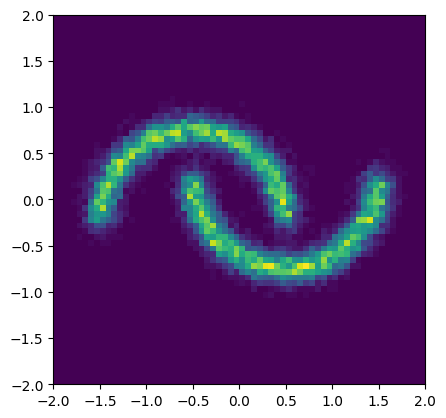

In [5]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [6]:
trainset = data.TensorDataset(*two_moons(15000))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
generator = Generator(z_dim=32, c_dim=1, y_dim=2, hidden_dim=1024, device=device)
discriminator = Discriminator(c_dim=1, y_dim=2, hidden_dim=1024, device=device)
discriminator, generator, history = train_wgan_gp_(generator, discriminator, trainloader, d_lr=2e-4, epochs=10, gp_lambda=5, n_critic=15)

Epoch 1/10 [train]:   0%|          | 0/235 [00:00<?, ?it/s]/home/giorgos/python/generative_models/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10 | D: -0.2767 | G: 0.3802


Epoch 2/10 | D: -0.1144 | G: 0.2270


Epoch 3/10 | D: -0.1619 | G: 0.2356


Epoch 4/10 | D: -0.1328 | G: 0.1950


Epoch 5/10 | D: -0.0918 | G: 0.1467


Epoch 6/10 | D: -0.0351 | G: 0.0900


Epoch 7/10 | D: 0.0230 | G: 0.0600


Epoch 8/10 | D: 0.6756 | G: 0.5315


Epoch 9/10 | D: 0.0586 | G: -0.2370


Epoch 10/10 | D: 0.0334 | G: -0.0780


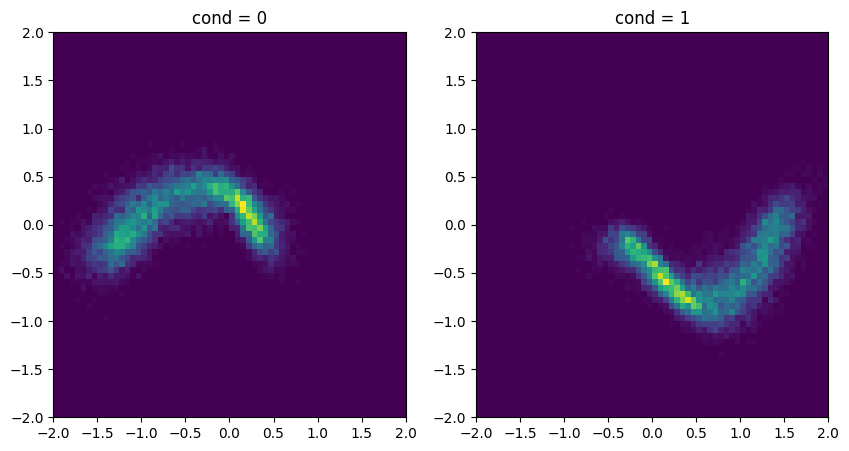

In [8]:
# Context dim = 1 (scalar condition)
c0 = torch.tensor([[0.0]])   # shape (1,1)
c1 = torch.tensor([[1.0]])   # shape (1,1)

# Generate samples separately
samps0 = generator.sample(10000, c0).view(-1, 2).cpu().numpy()
samps1 = generator.sample(10000, c1).view(-1, 2).cpu().numpy()

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(*samps0.T, bins=64, range=((-2, 2), (-2, 2)))
axs[0].set_title("cond = 0")
axs[1].hist2d(*samps1.T, bins=64, range=((-2, 2), (-2, 2)))
axs[1].set_title("cond = 1")
plt.show()
